<a href="https://colab.research.google.com/github/GrichinNikita2019/yandex_praktikum_da/blob/main/ml_customer_churn/ml_customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ взаимодействия с клиентами в сети фитнес-центров «Культурист-датасаентист»

**Задачи проекта**:
* Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента,
* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства,
* Проанализировать основные признаки, наиболее сильно влияющие на отток,
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. Выделить целевые группы клиентов;
    2. Предложить меры по снижению оттока;
    3. Определить другие особенности взаимодействия с клиентами.

**План работы:**
1. Шаг 1. Загрузить данные и подготовить их к анализу,
2. Шаг 2. Провести исследовательский анализ данных (EDA),
3. Шаг 3. Построить модель прогнозирования оттока клиентов,
4. Шаг 4. Сделать кластеризацию клиентов,
5. Шаг 5. Сформулировать выводы и сделать базовые рекомендации по работе с клиентами.

**Описание данных:**

В нашем распоряжении датасет gym_churn.

**Структура данных:**

* Churn — *факт оттока в текущем месяце*
* Текущие поля в датасете:*
    * gender — *пол*
    * Near_Location — *проживание или работа в районе, где находится фитнес-центр*
    * Partner — *сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)*
    * Promo_friends — *факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)*
    * Phone — *наличие контактного телефона*
    * Age — *возраст*
    * Lifetime — *время с момента первого обращения в фитнес-центр (в месяцах)*
* Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:*
    * Contract_period — *длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)*
    * Month_to_end_contract — *срок до окончания текущего действующего абонемента (в месяцах)*
    * Group_visits — *факт посещения групповых занятий*
    * Avg_class_frequency_total — *средняя частота посещений в неделю за все время с начала действия абонемента*
    * Avg_class_frequency_current_month — *средняя частота посещений в неделю за предыдущий месяц*
    * Avg_additional_charges_total — *суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон*

## Изучение данных из файла

### Импорт библиотек, настройка отображения данных и загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
plt.style.use('dark_background')
register_matplotlib_converters()
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/gym_churn.csv')

### Изучение таблицу gym_churn

In [ ]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227,5.000,3,0.020,0.000,0
1,0,1,0,0,1,12,1,31,113.203,12.000,7,1.923,1.910,0
2,0,1,1,0,1,1,0,28,129.448,1.000,2,1.859,1.737,0
3,0,1,1,1,1,12,1,33,62.670,12.000,2,3.206,3.357,0
4,1,1,1,1,1,1,0,26,198.362,1.000,3,1.114,1.120,0


Сразу виден один недостаток - использование в заголовках символов одновременно в верхнем и нижнем регистре. Поправим.

In [ ]:
df.columns = df.columns \
               .str \
               .lower()

In [ ]:
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Другое дело - теперь у нас красивые названия переменных.

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Типы данных для переменных подобраны адекватно их содержанию. Количество используемой памяти также достаточно мало (memory usage: 437.6 KB), поэтому данные не нуждаются в оптимизации.

Теперь проверим данные на наличие пропусков.

In [ ]:
pd.DataFrame(round((df.isna().mean()*100),2),
             columns = ['share_of_missing_values']) \
            .style.background_gradient('coolwarm')

,share_of_missing_values
gender,0
near_location,0
partner,0
promo_friends,0
phone,0
contract_period,0
group_visits,0
age,0
avg_additional_charges_total,0
month_to_end_contract,0


Ура, в данных нет пропусков! Теперь проверим данные на дубликаты.

In [ ]:
df.duplicated().sum()

0

Дубликаты в данных также отсутствуют.

**Можно сделать вывод:**

В данном наборе данных нет существенных недостатков: отсутствуют пропущенные значения, дубликаты, типы данных установлены адекватно.

**Общие выводы по разделу:**

1. На этапе предобработки был обнаружен недостаток, который был исправлен:
- Заголовки содержали одновременно символы верхнего и нижнего регистра;
2. В остальном в предоставленных данных не наблюдается заметных недостатков: пропуски данных и дубликаты отсутствуют.

## Исследовательский анализ данных (EDA)

### Общий взгляд на признаки

**Задача:**

Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe());

In [ ]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000
mean,0.510,0.845,0.487,0.308,0.903,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.500,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.000,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.000,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.000,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.000,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


По графику можно заключить:
1. **gender**: По полу группы делятся пополам. На данном этапе нет предположений, кто более склонен к оттоку.
2. **near_location**: Большинство (85%) людей проживают или работают в районе, где находится фитнес-центр. Можно выдвинуть гипотезу, что такие люди будут менее склонны к оттоку, так как для них посещение представляет меньше логистических трудностей.
3. **partner**: Почти половина выборки (49%) ходят в клуб по "партнерке". Предположительно данная аудитория будет менее склонна к оттоку, так как у данной аудитории может быть выше лояльность к рассматриваемому центру за счет скидок, бонусов и т.д.
4. **promo_friends**: По приглашению друга в зал ходит треть аудитории (30%). Вероятнее всего для этих людей будет менее характерна тенденция к оттоку, так как коллективное посещение дает дополнительную мотивацию к продолжению тренировок.
5. **phone**: Контактный телефон оставило подавляющее большинство посетителей центра (90%). Оставившие  гипотетически менее склонны к оттоку, так как с ними будет возможно связаться при первых признаках исчезновения.
6. **contract_period**: Средняя длительность текущего абонемента составляет 4,5 месяца. Чем больше период контракта, тем больше шанс, что человек не попадет в отток, так как он заплатил больше денег и, вероятно, имеет более серьезные и долгосрочные планы.
7. **group_visits** - Групповые занятия посещают чуть менее половины посетителей (41%). Посещающие такие занятие вероятно менее склонны к оттоку (логика аналогична переменной promo_friends).
8. **age**: Средний возраст в выборке составляет 29 лет. На данном этапе нет предположений, какая возрастная категория более склонна к оттоку.
9. **avg_additional_charges_total**: Средняя суммарная выручка от других услуг фитнес-центра составлет 146.944. Гипотеза: у людей с большими значениями данного показателя будет меньшая вероятность попасть в группу оттока.
10. **month_to_end_contract**: Среднее время в месяцах до окончания контракта составляет 4.323. Вероятнее всего люди, у которых осталось меньше времени до окончания контракта, будут больше попадать в отток, так как "к последним занятиям можно относиться менее серьезно"
11. **lifetime**: Среднее значение составлет 3.725. Относительно гипотезы логика та же, что и с предыдущей переменной.
12. **avg_class_frequency_total**: Средняя частота посещений составляет 1.879. Вероятнее всего, чем она выше, тем меньше вероятность попасть в группу оттока
13. **avg_class_frequency_current_month**: Средняя частота посещений в текущий месяц составляет 1.767. Гипотеза аналогична предыдущей.

### Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

**Задача:**

Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby());

In [ ]:
df.groupby('churn') \
  .mean() \
  .T

churn,0,1
gender,0.510,0.511
near_location,0.873,0.768
partner,0.534,0.355
promo_friends,0.354,0.184
phone,0.904,0.903
contract_period,5.747,1.729
group_visits,0.464,0.269
age,29.977,26.990
avg_additional_charges_total,158.446,115.083
month_to_end_contract,5.283,1.663


**Задача:**

Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

Для категориальных переменных с бинарными значениями построим столбчатые диаграммы.

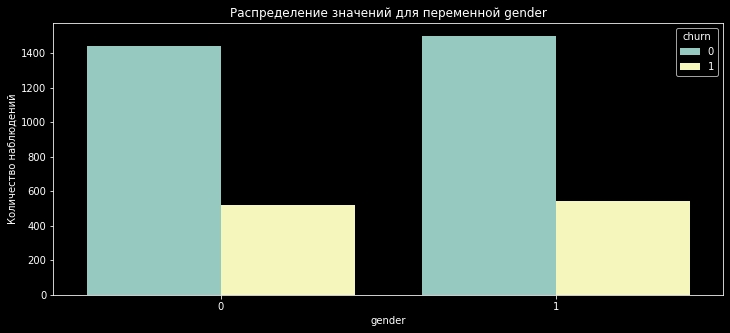

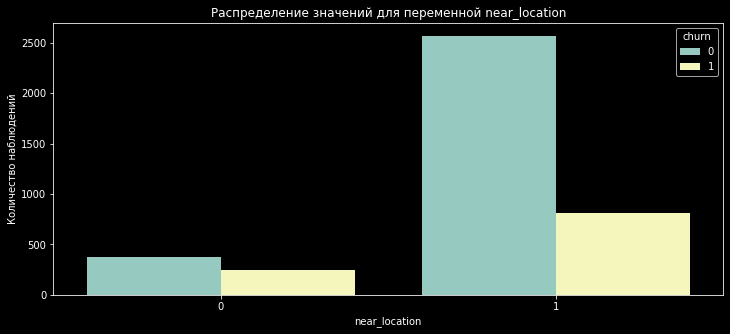

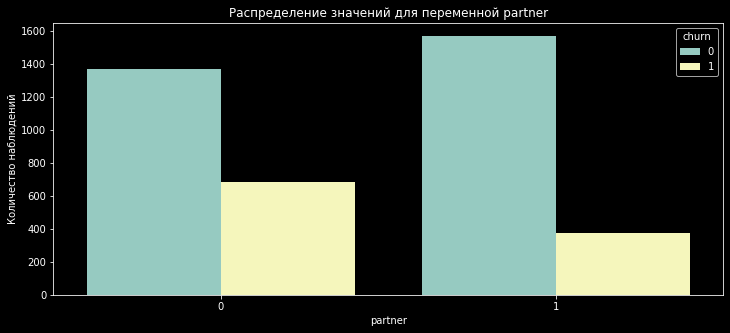

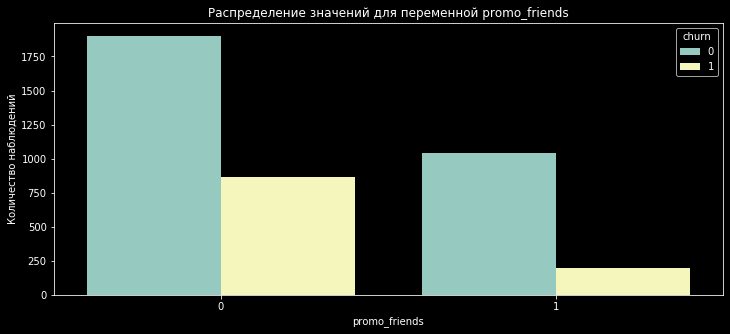

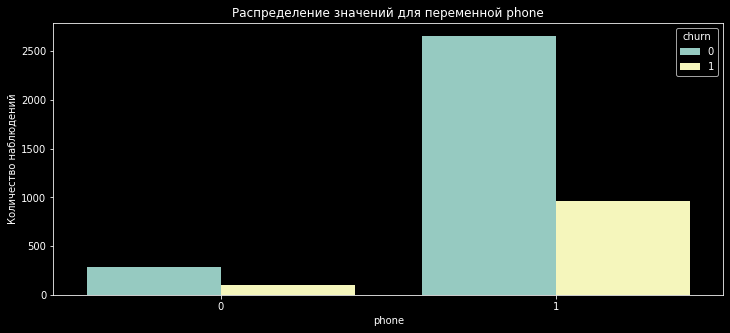

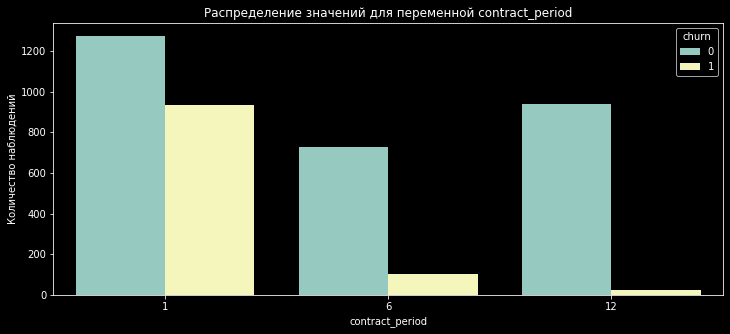

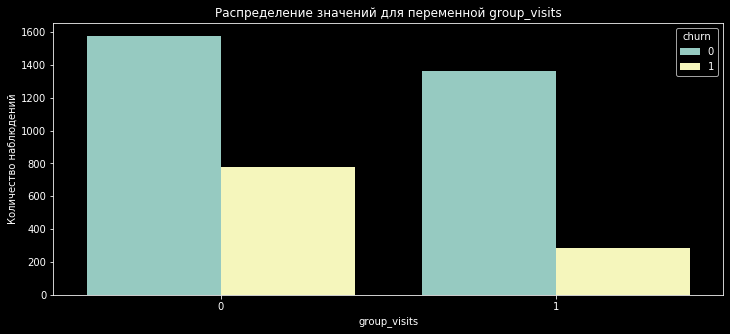

In [ ]:
binary = ['gender', 'near_location', 'partner', 'promo_friends', 'phone','contract_period','group_visits']
for column in binary:
    plt.figure(figsize=(12,5))
    sns.countplot(x = df[column], hue='churn', data=df)
    plt.title(f"Распределение значений для переменной " + str(column))
    plt.ylabel("Количество наблюдений")
    plt.show()

А теперь отдельно для переменных с интервальными переменными построим ящики с усами.

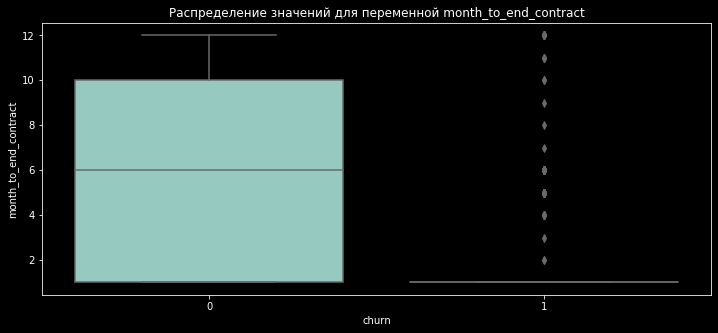

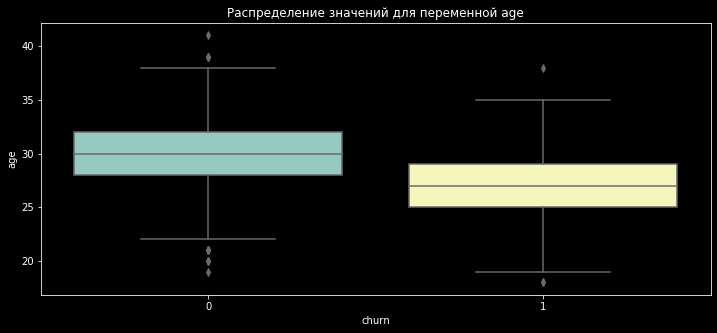

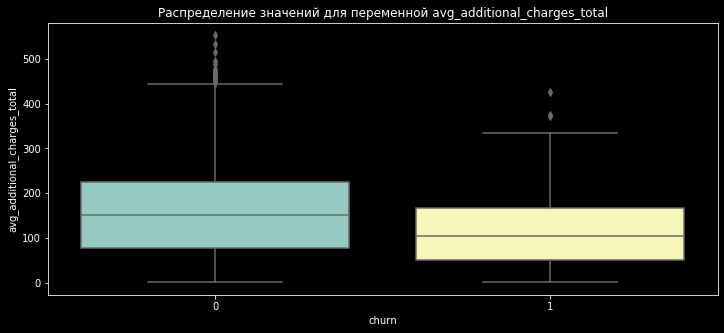

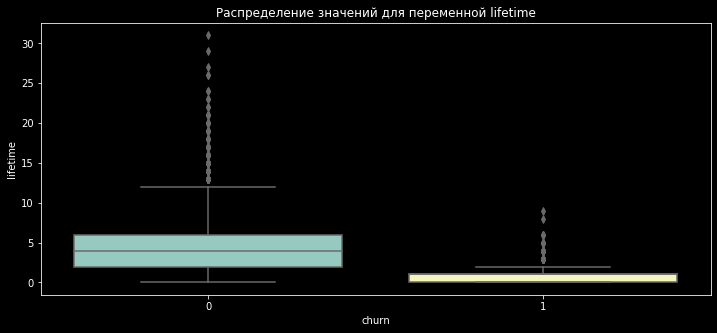

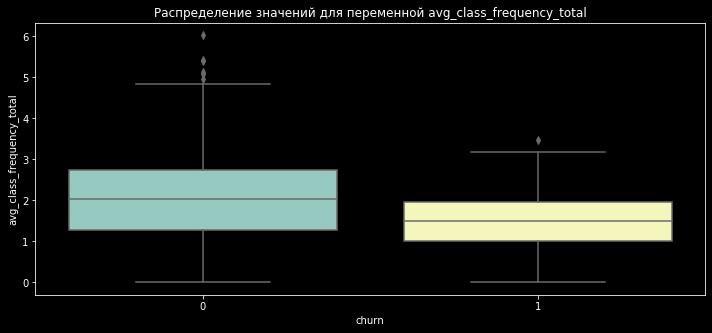

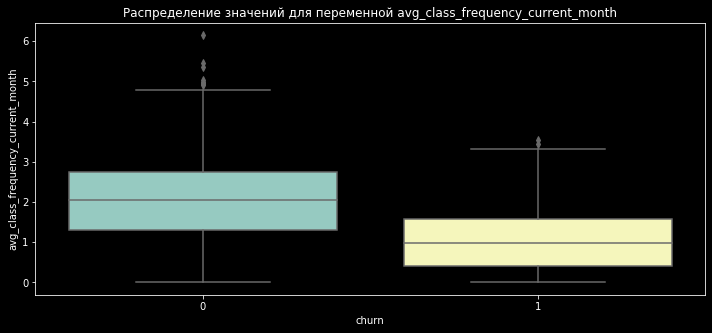

In [ ]:
bp = ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
for column in bp:
    plt.figure(figsize=(12,5))
    sns.boxplot(x = 'churn', y = df[column], data = df)
    plt.title(f"Распределение значений для переменной " + str(column))
    plt.show()

**Можно заключить, что**:

1. Большинство гипотез, выдвинутых в предыдущем разделе, выглядят правдоподобно
2. Практически нет отличия в показателях по переменным gender и phone. Скорее всего они будут наименее важны для дальнейшего построения модели.

**Задача:**

Постройте матрицу корреляций и отобразите её.;

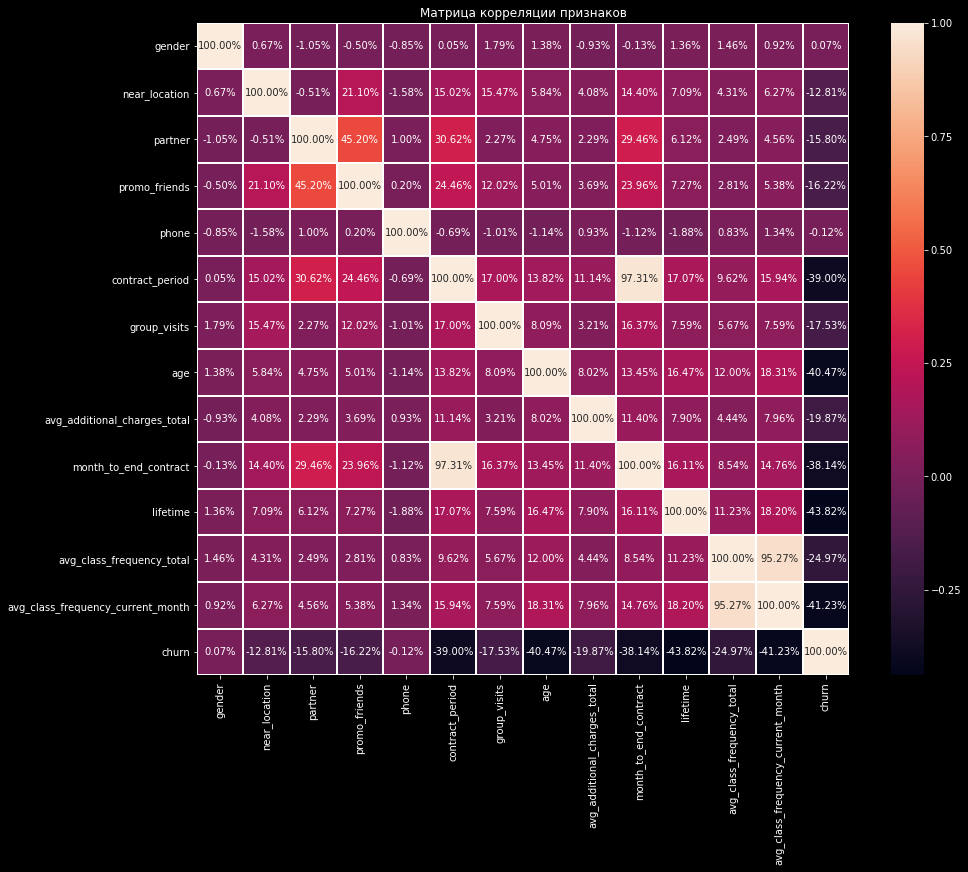

In [ ]:
cm = df.corr()
plt.figure(figsize = (15, 12))
plt.title('Матрица корреляции признаков')
ax = sns.heatmap(cm,annot=True, square=True,fmt='.2%',linewidths=1)
plt.show()

По матрице корреляции можно сделать следующие выводы:
1. Как и писали ранее, признаки phone и gender никак не коррелируют с переменной churn, поэтому их предсказательная сила скорее всего будет минимальна для нашей модели.
2. Есть признаки, корреляция между которыми выражена сильно (более 80%):
    * contract_period - month_to_end_contract (97,3%)
    * avg_class_frequency_current_month и avg_class_frequency_total (95,27%)
    
**Так как логистическая регрессия относится к категории линейных моделей, последнюю проблему необходимо решить**: в данном случае, поскольку переменные отображают приблизительно одно и то же, оставим по одной переменной из каждой пары (те, у которых большая корреляция с целевой переменной, то есть contract_period и avg_class_frequency_current_month). Сделаем это сейчас.

In [ ]:
df = df.drop(['avg_class_frequency_total','month_to_end_contract'], axis = 1)

## Модель прогнозирования оттока клиентов

#### Разбиение данных

In [ ]:
X = df.drop('churn', axis = 1)
y = df['churn']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

Так как логистическая регрессия это линейная модель, а наши переменные имеют разную размерность, данные перед обучением необходимо стандартизировать.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [ ]:
lg_model = LogisticRegression(solver='liblinear', random_state=0)
lg_model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lg_predictions = lg_model.predict(X_test_st)
lg_probabilities = lg_model.predict_proba(X_test_st)[:,1]

In [ ]:
print('Метрики для модели логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lg_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lg_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lg_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, lg_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, lg_predictions)))

Метрики для модели логистической регрессии
Accuracy: 0.92
Precision: 0.85
Recall: 0.84
F1: 0.84
ROC_AUC: 0.89


Неплохие результаты. Доля верных ответов 90% при ROC_AUC 88%. Сравним с лесом. Лес в отличие от регрессии не нуждается в стандартизации, поэтому будем передавать нестандартизированные данные.

In [ ]:
rf_model = RandomForestClassifier(random_state = 0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [ ]:
print('Метрики для модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_predictions)))

Метрики для модели случайного леса
Accuracy: 0.89
Precision: 0.84
Recall: 0.73
F1: 0.78
ROC_AUC: 0.84


Бейслайны для обоих моделей готовы и по большинству метрик логистическая регрессия показывает более высокие результаты, однако для леса есть возможность попробовать подобрать параметры, чем и предлагаем заняться!

In [ ]:
def best_metrics_random_forest(X_train, X_test, y_train, y_test, cw=None):
    """
    input: X_train, X_test, y_train, y_test - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели случайного леса
    output: None
    description: функция обучает модель решающего дерева RandomForestClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for n_estimators in range(10,200,10):
        for max_depth in range(10,17,2):
            for min_samples_split in range(2,5):
                for min_samples_leaf in range(1,4):
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=0,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_test)

                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_test, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_test, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_roc_auc = roc_auc

    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))

    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [ ]:
best_metrics_random_forest(X_train, X_test, y_train, y_test)

Наилучшая метрика f1: 0.845
    Парамтеры модели:
       n_estimators = 150
       max_depth = 16
       min_samples_split = 4
       min_samples_leaf = 1 

Наилучшая метрика roc_auc: 0.89
    Парамтеры модели:
       n_estimators = 150
       max_depth = 16
       min_samples_split = 4
       min_samples_leaf = 1 


Попробуем использовать данные гиперпараметры.

In [ ]:
rf_model = RandomForestClassifier(random_state = 0, n_estimators = 150, max_depth = 16, min_samples_split = 4, min_samples_leaf = 1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [ ]:
print('Метрики для модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_predictions)))

Метрики для модели случайного леса
Accuracy: 0.92
Precision: 0.87
Recall: 0.83
F1: 0.85
ROC_AUC: 0.89


Бинго, удалось поднять значения всех метрик, теперь эффективность моделей приблизительно равнозначна, однако логистическая регрессия все еще на несколько десятых лучше по ROC_AUC, поэтому она предпочтительнее.

Напоследок также посмотрим на вклад переменных в предсказательную силу нашей модели.

In [ ]:
pd.DataFrame({"feature": df.iloc[:, :-1].columns,
             "importances": rf_model.feature_importances_}).sort_values(by="importances", ascending=False)

,feature,importances
9,lifetime,0.337
10,avg_class_frequency_current_month,0.209
7,age,0.147
5,contract_period,0.120
8,avg_additional_charges_total,0.110
6,group_visits,0.019
2,partner,0.014
0,gender,0.013
3,promo_friends,0.012
1,near_location,0.011


Наиболее важные для модели признаки:
1. lifetime
2. avg_class_frequency_current_month
3. age
4. contract_period
5. avg_additional_charges_total

Это те показатели, над которыми стоит работать фитнес-центру. Например, частоту посещения можно пытаться повышать за счет геймификации процессов. Например, давать бонусы за регулярное частое посещение, которые в дальнейшем можно тратить на дополнительные услуги.

Можно продвигать более долгие варианты контракта за счет скидок и промо.

## Кластеризация клиентов

**Задача:**

Стандартизируйте данные;

In [ ]:
sc = StandardScaler()
x_sc = sc.fit_transform(df)

Готово

**Задача:**

Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. Внимание: отрисовка дендрограммы может занять время! На основании полученного графика предположите, какое количество кластеров можно выделить.;

In [ ]:
linked = linkage(x_sc, method = 'ward') 

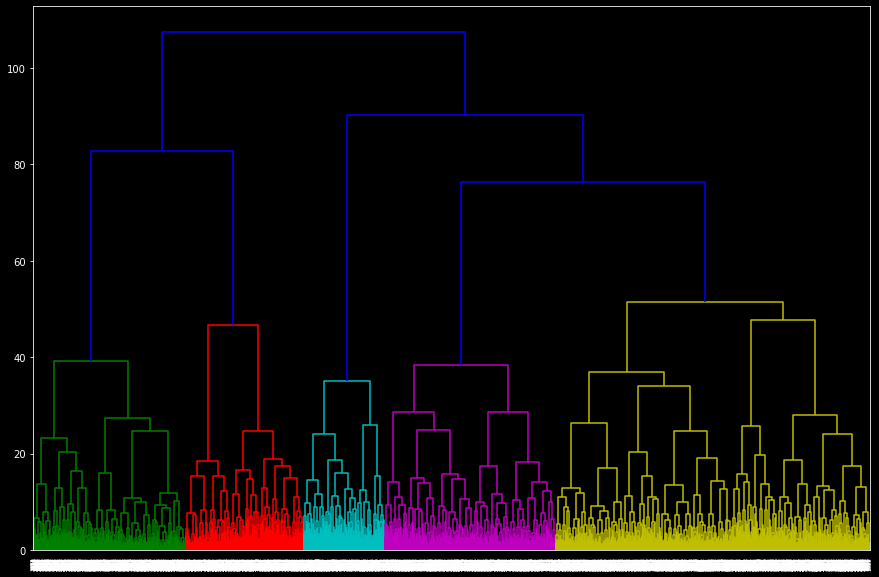

In [ ]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Наиболее удачное количество кластеров на дендограмме: 5

**Задача:**

Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. Договоримся за число кластеров принять n=5, чтобы ваши результаты можно было сравнивать с результатами остальных студентов. Однако, конечно, в жизни никто не скажет вам правильный ответ, и решение остаётся за вами (на основании изучения графика из предыдущего пункта).

In [ ]:
km = KMeans(n_clusters = 5,random_state = 0)

In [ ]:
labels = km.fit_predict(x_sc)

In [ ]:
df['cluster_km'] = labels

In [ ]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(x_sc, labels)))

Silhouette_score: 0.16


Не самое высокое значение параметра, но и не самое низкое.

In [ ]:
df['cluster_km'].value_counts()

1    1290
3    1037
4     730
0     557
2     386
Name: cluster_km, dtype: int64

Наблюдения разбились по кластерам не совсем равномерно, но их наполненность достаточна для сравнения.

In [ ]:
df.groupby('cluster_km') \
  .mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
0,0.501,0.000,0.487,0.074,1.000,2.989,0.237,28.700,137.061,2.987,1.594,0.404
1,0.516,0.999,0.216,0.055,1.000,3.871,0.460,30.053,160.909,4.747,2.050,0.002
2,0.523,0.863,0.472,0.306,0.000,4.777,0.427,29.298,144.208,3.940,1.724,0.267
3,0.501,0.992,0.936,0.810,1.000,8.633,0.527,29.927,158.816,4.702,2.031,0.006
4,0.514,1.000,0.336,0.225,1.000,1.740,0.290,26.903,114.387,0.978,1.046,0.993


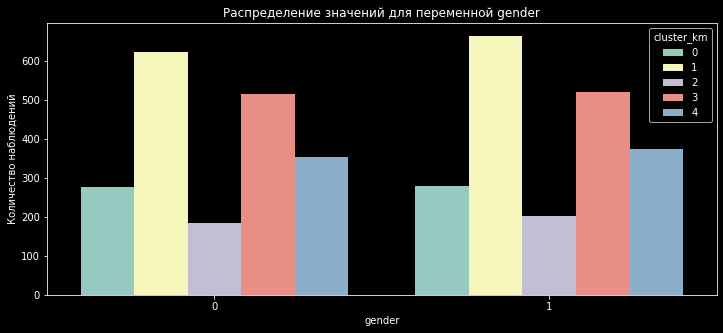

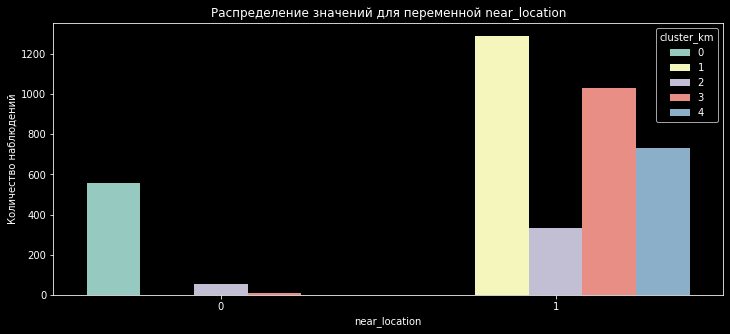

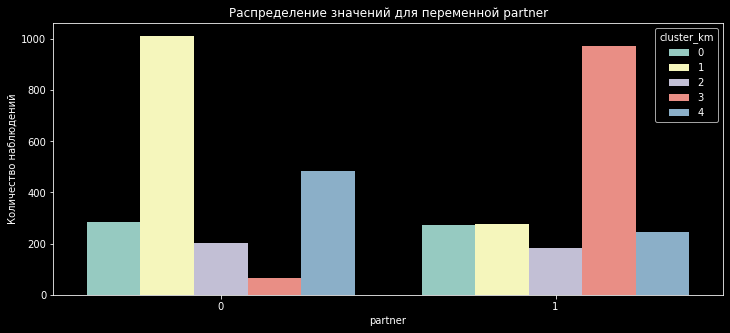

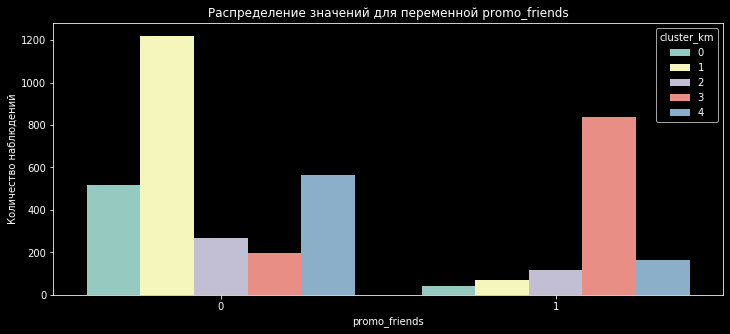

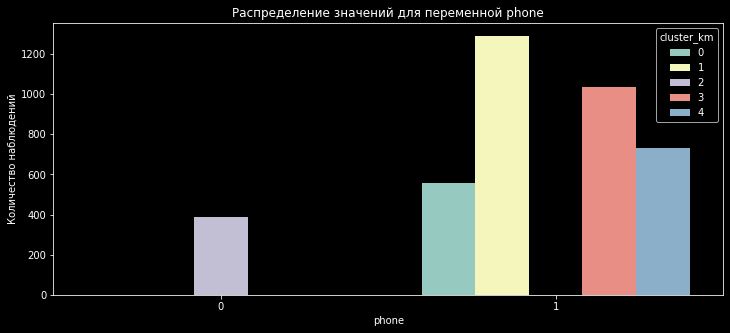

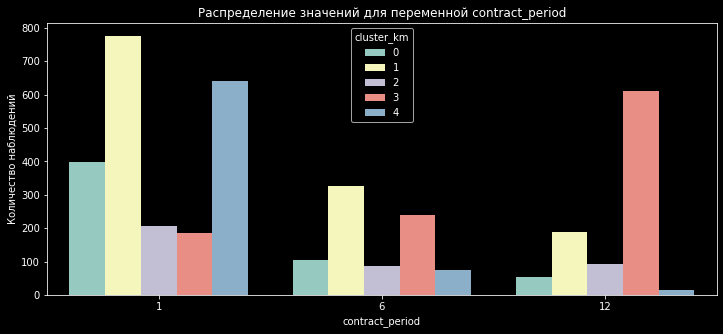

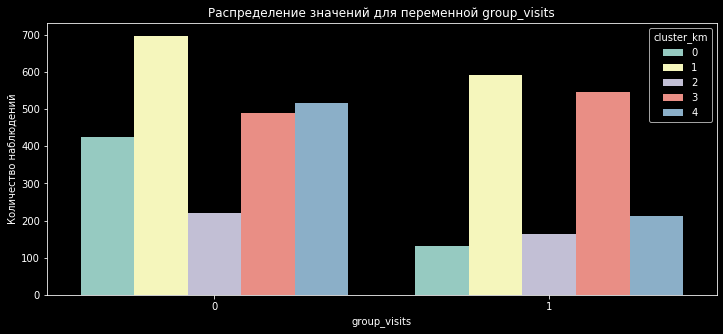

In [ ]:
for column in binary:
    plt.figure(figsize=(12,5))
    sns.countplot(x = df[column], hue='cluster_km', data=df)
    plt.title(f"Распределение значений для переменной " + str(column))
    plt.ylabel("Количество наблюдений")
    plt.show()

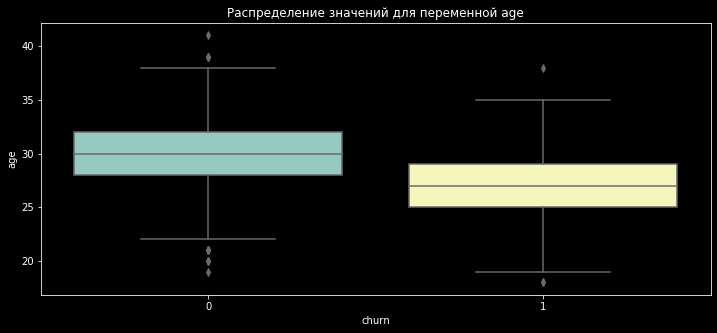

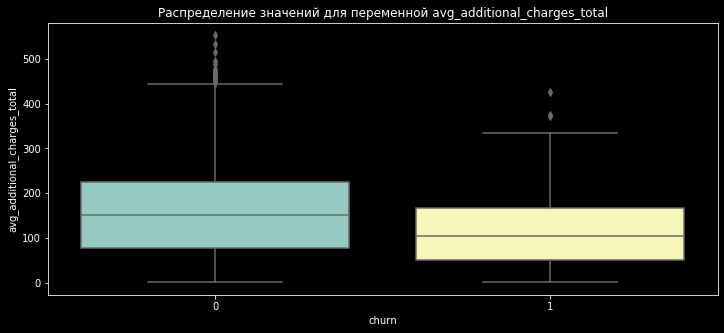

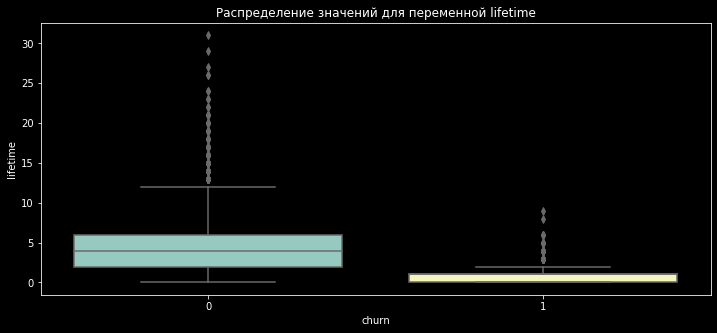

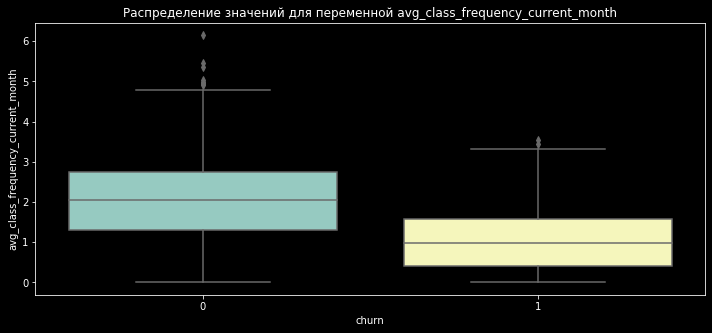

In [ ]:
bp_new = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']
for column in bp_new:
    plt.figure(figsize=(12,5))
    sns.boxplot(x = 'churn', y = df[column], data = df)
    plt.title(f"Распределение значений для переменной " + str(column))
    plt.show()

**Наиболее склонны к оттоку представители кластера 4**. Их можно охарактеризовать следующим образом:
* Все представители живут рядом с фитнес-центром
* Большая часть из не работает в партнерских организациях
* Пришли скорее не по приглашению друга
* Заключают контракт на короткий срок
* Почти не посещают групповые занятия
* Наиболее молодой кластер
* Их расходы на дополнительные услуги меньше, чем в остальных кластерах
* Наиболее низкий lifetime
* Наиболее низкая частота посещения в последний месяц

**Наименее склонны к оттоку представители кластера 1**. Их можно охарактеризовать следующим образом:
* Подавляющее большинство представителей живут рядом с фитнес-центром
* Большая часть из не работает в партнерских организациях
* Пришли скорее не по приглашению друга
* Средний относительно других кластеров период контаркта
* Многие посещает групповые занятия
* Самые старые
* У них наибольшие расходы на дополнительные услуги
* Наиболее высокий среди кластеров lifetime
* У них самая большая частота посещения

**Также наименее склонен к оттоку кластер 3**. Их можно охарактеризовать следующим образом:
* Подавляющее большинство представителей живут рядом с фитнес-центром
* Занимаются в большинстве своем по "партнерке"
* Приглашены друзьями
* У них самый длинный период контракта
* Они чаще остальных занимаются в группах
* Также один из наиболее старых кластеров
* Почти не отстают по расходам от предыдущих
* Они на втором месте по lifetime
* Посещают лишь чуть реже предыдущих

## Выводы и рекомендации

***Основные выводы исследования:***

1. Рекомендуется сосредоточиться на увеличении следующих показателей:
* lifetime (скидки и бонусы старым клиентам)
* avg_class_frequency_current_month (геймификация, бонусы за регулярное и постоянное посещение)
* age (больше таргетировать на взрослую аудиторию)
* contract_period (больше сконцентрироваться на продвижении более длительных контрактов)
* avg_additional_charges_total
2. Оказывать всевозможную поддержку представителям 1 и 3 класса.
3. Выстроить предиктивную систему аналитики, чтобы предпринимать меры по удержанию клиентов, оказавшихся в группе риска к оттоку.